In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from statsmodels.api import OLS,Logit
from sklearn.metrics import roc_curve,roc_auc_score
from scipy.stats import *

/home/users/magu/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dataset='all_z_center_p001_20190805'

# phenotypes to analyze
phe_codes=['INI21001','HC326','HC328']

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
scores=reduce(lambda x,y: pd.merge(x,y,left_index=True,right_index=True),
              map(lambda phe: pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/PRS/train/'+
                                               dataset+'/'+phe+'_PRS.profile', sep='\s+',
                                            usecols=['IID','SCORESUM'],
                                            index_col='IID').rename(columns={'SCORESUM':phe+'_PRS'}),
                  phe_codes))
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9)

# analysis population
val=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                      'ukb24983_white_british_test.phe').iloc[:,0].tolist())
train=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                        'ukb24983_white_british_valid.phe').iloc[:,0].tolist())
# phenotype names
with open('/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

# program some special cases
code_to_name['INI21001'] = 'Body mass index'
code_to_name['HC294'] = 'Renal failure'
code_to_name['HC326'] = 'Myocardial infarction'
code_to_name['INI10030880'] = 'Serum urate'

INI21001
29.8722044643
27.4011526771
HC326
0.129080118694
0.0363048539946
HC328
0.0949554896142
0.0195761467618


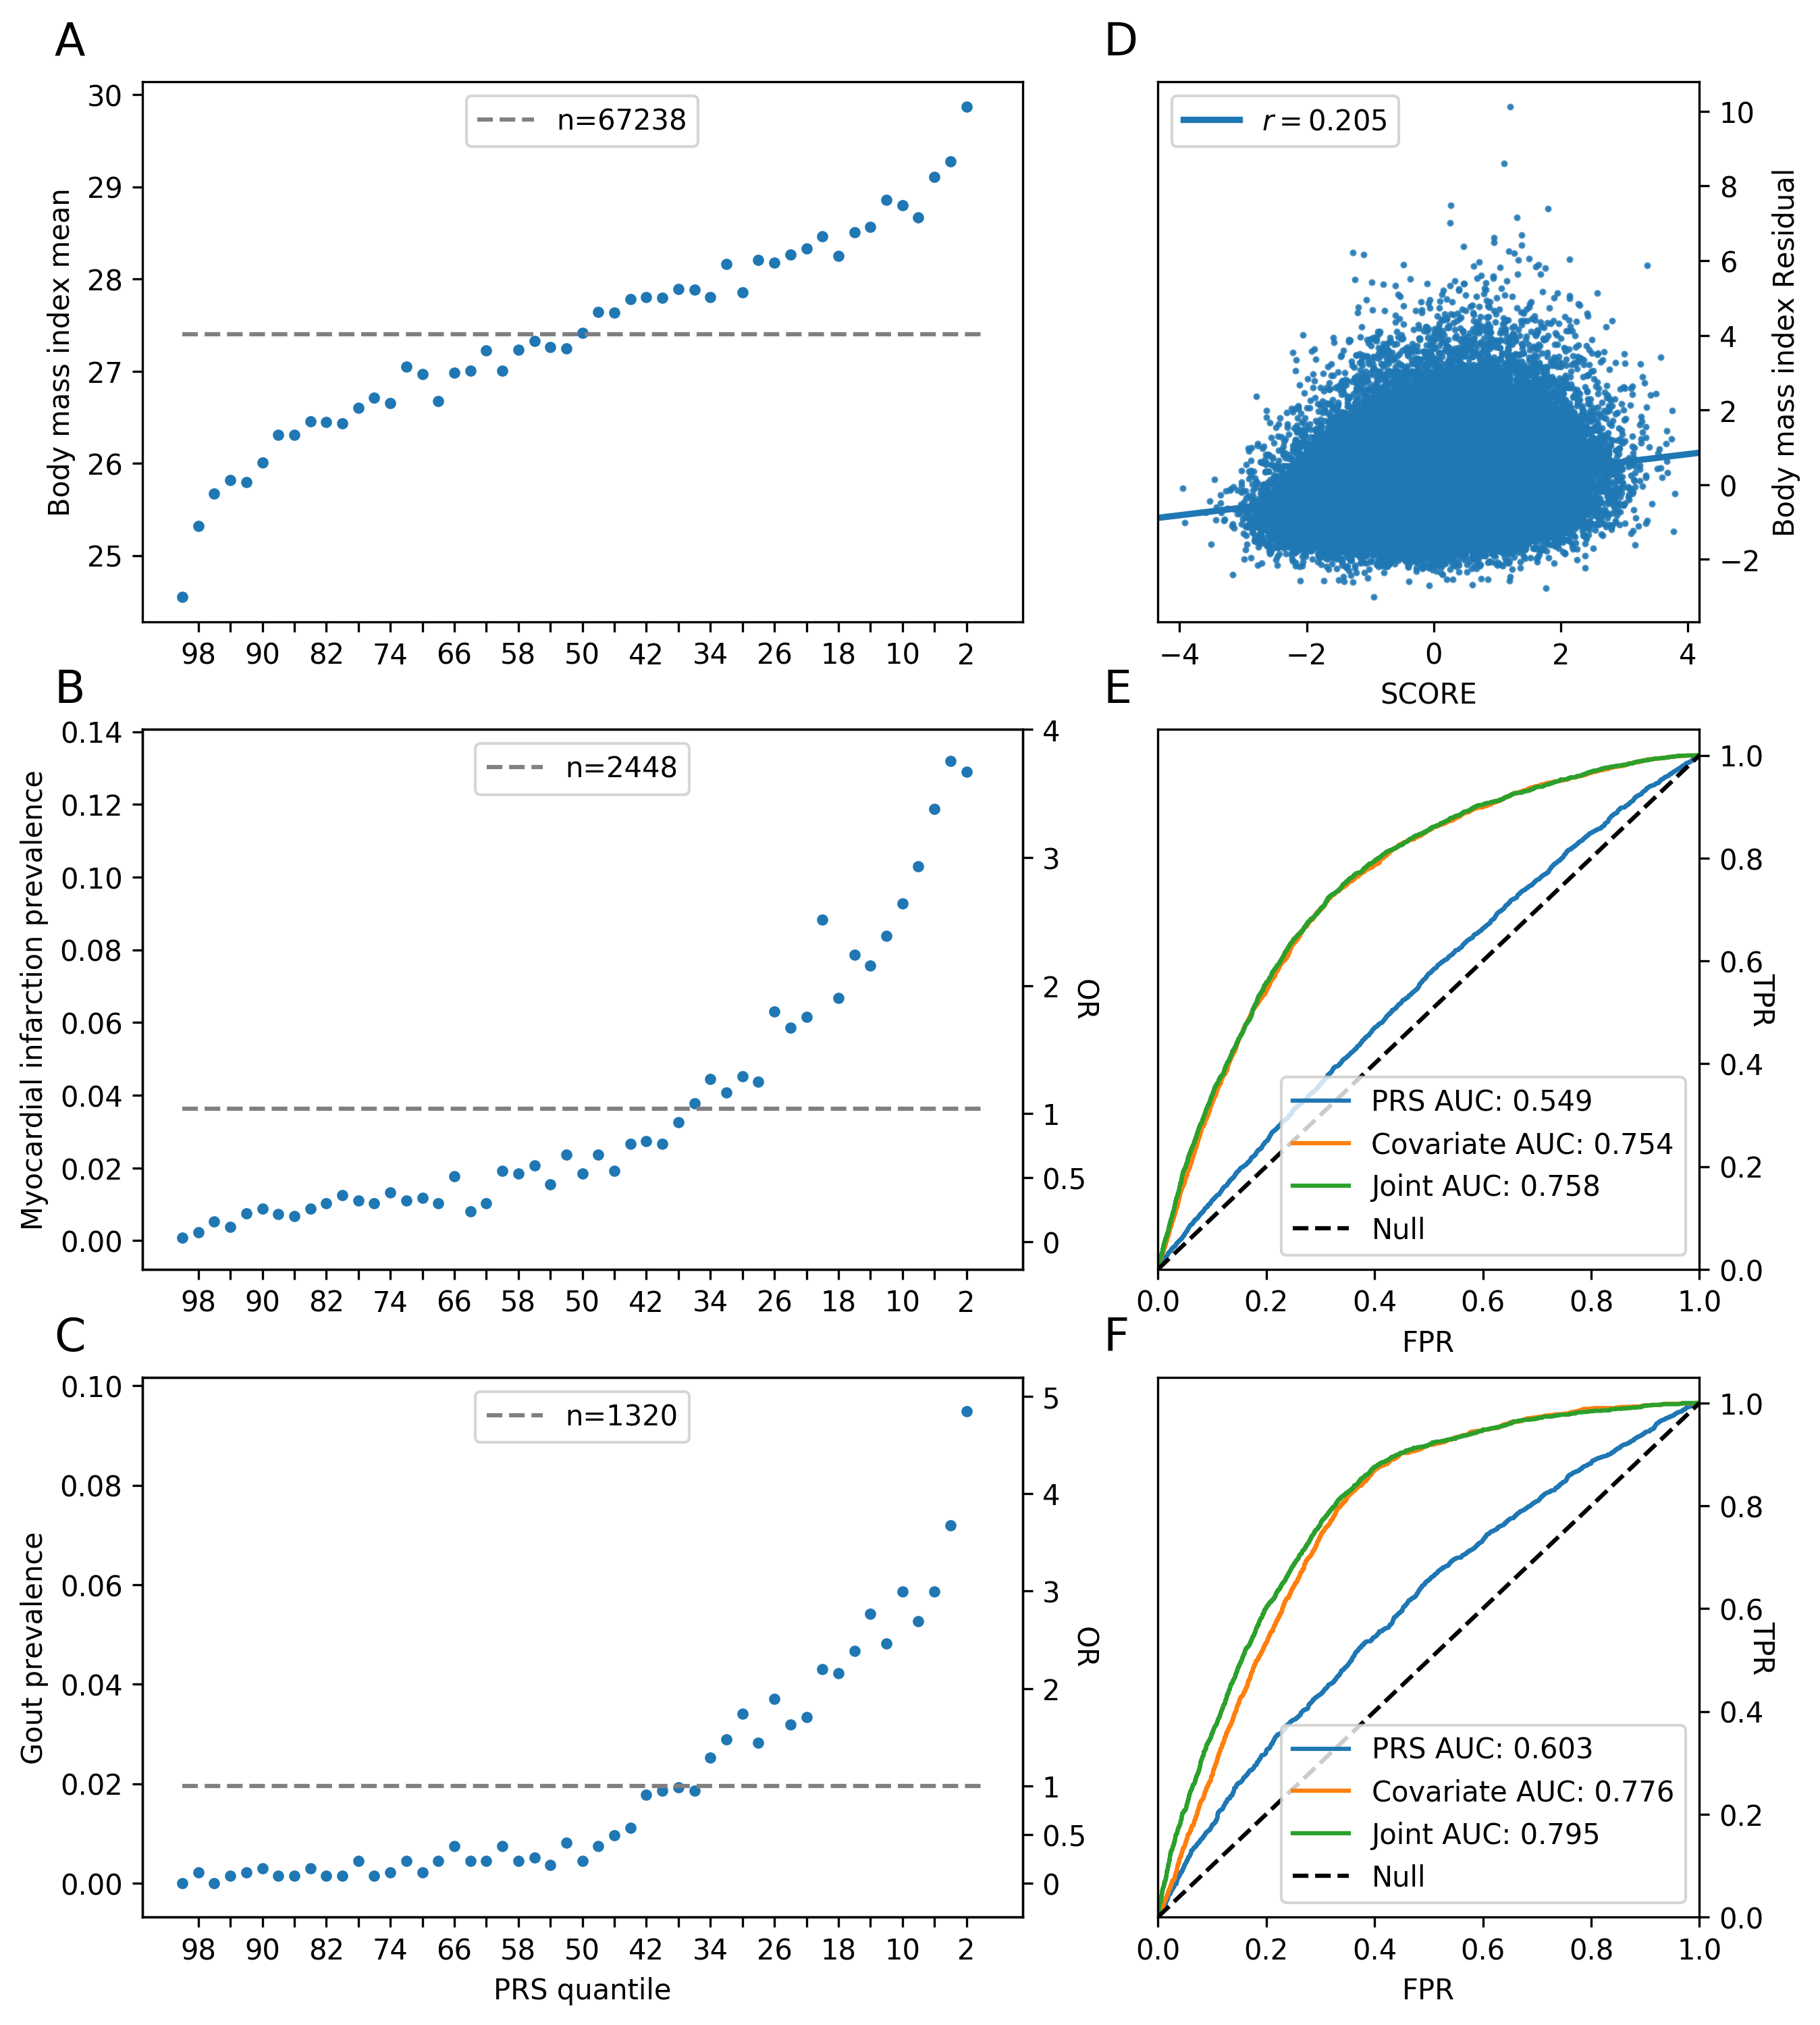

In [8]:
width = 2
# initialize plot objects
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(5*width + 1, 4*len(phe_codes)), dpi=300)
grid=gs.GridSpec(4*len(phe_codes), 5*width + 1, wspace=4, hspace=2)
for i,phe_code in enumerate(phe_codes):
    score=phe_code+'_PRS'
    for ix in range(width):
        plots[(width*i)+ix]=plt.subplot(grid[i*4:(i+1)*4, (6*ix):(6-(7*ix))])
    # scores and phenotypes
    phe_name=code_to_name[phe_code]
    df=phenos.loc[val,[phe_code]+covariate].dropna()
    dg=phenos.loc[train,[phe_code]+covariate].dropna()
    
    n=df.shape[0]
    df['SCORE']=zscore(scores.loc[df.index.tolist(),score])
    dg['SCORE']=zscore(scores.loc[dg.index.tolist(),score])
    df.sort_values(by='SCORE',ascending=True,inplace=True)
    dg.sort_values(by='SCORE',ascending=True,inplace=True)
    # this is to add an intercept in the regression models below
    df['1']=1
    dg['1']=1
    covariates=covariate+['1']
    # start with check for bin/qt, and plotting distributions/AUC
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        df[phe_code]-=1 # remove plink binary format
        dg[phe_code]-=1
        # loop over PRS and these joint models
        cov_prs=Logit(dg[phe_code],dg[covariates]).fit(disp=0).predict(df[covariates])
        jnt_prs=Logit(dg[phe_code],dg[covariates+['SCORE']]).fit(disp=0).predict(df[covariates+['SCORE']])        
        #cov_prs=Logit(df[phe_code],df[covariates]).fit(disp=0).fittedvalues
        #jnt_prs=Logit(df[phe_code],df[covariates+['SCORE']]).fit(disp=0).fittedvalues
        for name,prs in zip(['PRS','Covariate','Joint'],[df['SCORE'],cov_prs,jnt_prs]):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(df[phe_code],prs)
            roc_auc=roc_auc_score(df[phe_code],prs)
            plots[(2*i)+1].plot(fpr,tpr,label=name+' AUC: '+'{:.3f}'.format(roc_auc))
        # add null line, axis labels
        plots[(2*i)+1].plot([0, 1],[0, 1],'k--',label='Null')
        plots[(2*i)+1].legend()
        plots[(2*i)+1].set_xlim([0.0, 1.0])
        plots[(2*i)+1].set_ylim([0.0, 1.05])
        plots[(2*i)+1].set_ylabel('TPR', rotation=270)
        plots[(2*i)+1].set_xlabel('FPR')
    else:
        is_bin=False
        # plot correlation with PRS and residual phenotype
        jnt_prs=zscore(OLS(dg[phe_code],dg[covariates+['SCORE']]).fit(disp=0).predict(df[covariates+['SCORE']]))
        prs=OLS(df[phe_code],df[covariates]).fit(disp=0).resid_pearson
        sns.regplot(x=df['SCORE'],y=prs,ax=plots[(2*i)+1],scatter_kws={'s':2})
        plots[(2*i)+1].set_ylabel(code_to_name[phe_code]+' Residual')
        plots[(2*i)+1].legend(['$r=$'+'{:.3f}'.format(pearsonr(prs,df['SCORE'])[0])])
    df['jnt']=jnt_prs
    df.sort_values(by='jnt', ascending=True, inplace=True)
    # now do quantile plot with modified (only if binary) phenotype
    nq=50
    plots[2*i].scatter(np.arange(nq), 
                       [df.iloc[int(q*n/nq):int((q+1)*n/nq),:][phe_code].mean() for q in range(nq)], 
                       s=9)
    # labels
    plots[2*i].set_ylabel(phe_name+' {}'.format('prevalence' if is_bin else 'mean'))
    plots[2*i].set_xticks(np.arange(1,nq+1,2))
    plots[2*i].set_xticklabels([int(100*q/nq) if q%4==1 else '' for q in reversed(range(1,nq+1,2))])
    plots[2*i].plot([0,nq],[df[phe_code].mean(),df[phe_code].mean()],'--',color='grey')
    plots[2*i].legend(['n={}'.format(int(df[phe_code].sum()) if is_bin else df.shape[0])], loc=9)
    plots[2*i].text(-0.1, 1.05, chr((i%len(phe_codes))+65), 
                    fontsize=16, transform=plots[2*i].transAxes)
    plots[(2*i)+1].text(-0.1, 1.05, chr((i%len(phe_codes))+65+len(phe_codes)), 
                        fontsize=16, transform=plots[(2*i)+1].transAxes)
    print(phe_code)
    print(df.iloc[-(n/nq):][phe_code].mean())
    print(df[phe_code].mean())
    if is_bin:
        m,b=(plots[2*i].get_ylim()[1]-plots[2*i].get_ylim()[0]),plots[2*i].get_ylim()[0]
        y_or=plots[2*i].twinx()
        y_or.set_yticks([(o*df[phe_code].mean()-b)/m for o in [0,0.5,1,2,3,4,5,6,7,8,9] 
                          if df.iloc[-(n/nq):,:][phe_code].mean() > (o-1)*df[phe_code].mean()])
        y_or.set_yticklabels(map(lambda s:str(s), #.rjust(4 if len(str(s)) < 3 else 3),
                                 filter(lambda o: df.iloc[-(n/nq):][phe_code].mean() > (o-1)*df[phe_code].mean(), 
                                        [0,0.5,1,2,3,4,5,6,7,8,9]))) 
        y_or.set_ylabel('OR', rotation=270)
    plots[(2*i)+1].yaxis.tick_right()
    plots[(2*i)+1].yaxis.set_label_position("right")
    # add x-axis labels at the very end
    if i==len(phe_codes)-1:
        plots[(2*i)].set_xlabel('PRS quantile')
    else:
        plots[(2*i)].set_xlabel('')
            
plt.show()
fig.savefig("Figure-S2.pdf", bbox_inches='tight')